In [ ]:
#define boolean that determines if the model should be trained or loaded
model_train = False

In [ ]:
#use mount instead if faster?
import io
import pandas as pd
from google.colab import files
!rm *.xlsx
uploaded = files.upload()

rm: cannot remove '*.xlsx': No such file or directory


Saving Cbasil_PHB_1G.xlsx to Cbasil_PHB_1G.xlsx
Saving Cbasil_PHB_LSMMG.xlsx to Cbasil_PHB_LSMMG.xlsx
Saving Ecoli_BC_1G.xlsx to Ecoli_BC_1G.xlsx
Saving Ecoli_BC_LSMMG.xlsx to Ecoli_BC_LSMMG.xlsx
Saving Ecoli_EYFP_1G.xlsx to Ecoli_EYFP_1G.xlsx
Saving Ecoli_EYFP_LSMMG.xlsx to Ecoli_EYFP_LSMMG.xlsx
Saving Ppas_BC_1G.xlsx to Ppas_BC_1G.xlsx
Saving Ppas_BC_LSMMG.xlsx to Ppas_BC_LSMMG.xlsx
Saving Ppas_BC_LUNAR.xlsx to Ppas_BC_LUNAR.xlsx
Saving Ppas_BC_MARTIAN.xlsx to Ppas_BC_MARTIAN.xlsx
Saving Ppas_Wild_1G.xlsx to Ppas_Wild_1G.xlsx
Saving Ppas_Wild_LSMMG.xlsx to Ppas_Wild_LSMMG.xlsx
Saving Ppas_Wild_LUNAR.xlsx to Ppas_Wild_LUNAR.xlsx
Saving Ppas_Wild_MARTIAN.xlsx to Ppas_Wild_MARTIAN.xlsx
Saving Pput_Wild_1G.xlsx to Pput_Wild_1G.xlsx
Saving Pput_Wild_LSMMG.xlsx to Pput_Wild_LSMMG.xlsx
Saving Scere_BC_1G.xlsx to Scere_BC_1G.xlsx
Saving Scere_BC_LSMMG.xlsx to Scere_BC_LSMMG.xlsx
Saving Scere_BC_LUNAR.xlsx to Scere_BC_LUNAR.xlsx
Saving Scere_BC_MARTIAN.xlsx to Scere_BC_MARTIAN.xlsx
Saving Sce

In [ ]:
import torch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [ ]:
organism_list = []
substance_list = []
gravity_list = []
obj_list = []

class Preprocess:
  def __init__(self, file_name):
    self.file_name = file_name
    self.organism, self.substance, self.gravity = self.file_name.split(".")[0].split()[0].split("_")
    self.update_list(organism_list, self.organism)
    self.update_list(substance_list, self.substance)
    self.update_list(gravity_list, self.gravity)

  def update_list(self, item_list, item):
    #if item not in item_list:
    item_list.append(item)

In [ ]:
for file_name in uploaded.keys():
  obj = Preprocess(file_name)
  obj_list.append(obj)

In [ ]:
from sklearn.preprocessing import LabelEncoder

organism_encode = LabelEncoder()
substance_encode = LabelEncoder()
gravity_encode = LabelEncoder()

organism_label = organism_encode.fit_transform(organism_list)
substance_label = substance_encode.fit_transform(substance_list)
gravity_label = gravity_encode.fit_transform(gravity_list)

In [ ]:
import numpy as np

data_list = []

class Data:
  def __init__(self,file_name, organism, substance, gravity):
    self.file_name = file_name
    self.organism = organism
    self.substance = substance
    self.gravity = gravity
    self.growth_time, self.growth_val = self.assign_data()
    self.growth_input_np = self.create_inputs(self.growth_time, self.growth_val)
    self.growth_val_np = self.growth_val.reshape(-1, 1)

  def assign_data(self):
    growth_df = pd.read_excel(self.file_name, sheet_name = 0).iloc[1:]
    growth_time = growth_df.iloc[:,:1].to_numpy()
    growth_df_transpose = growth_df.iloc[:,1:].T
    growth_df_transpose.fillna(growth_df_transpose.mean(), inplace = True)
    growth_val = growth_df_transpose.T.to_numpy()

    return growth_time, growth_val

  def create_inputs(self, input, output):
    """
    Returns inputs in order of organism, substance, gravity, and time
    """
    input_length = len(input)
    output_length = len(output[0])

    input_stacked = np.tile(input, output_length).reshape(-1, 1)

    categorical_inputs = [self.organism, self.substance, self.gravity]
    categorical_inputs_stacked = np.tile(categorical_inputs, input_length * output_length).reshape(-1, len(categorical_inputs))

    return np.hstack((categorical_inputs_stacked, input_stacked)).astype(float)

In [ ]:
for i, obj in enumerate(obj_list):
  data_obj = Data(obj.file_name, organism_label[i], substance_label[i], gravity_label[i])
  data_list.append(data_obj)

In [ ]:
#aggregate inputs and outputs
growth_input = data_list[0].growth_input_np
growth_output = data_list[0].growth_val_np

for i in range(1, len(data_list)):
  growth_input = np.vstack((growth_input, data_list[i].growth_input_np))
  growth_output = np.vstack((growth_output, data_list[i].growth_val_np))

In [ ]:
#standardize time
growth_time_input_mean = np.mean(growth_input[:, 3])
growth_time_input_std_dev = np.std(growth_input[:, 3])
growth_input[:,3] = (growth_input[:, 3] - growth_time_input_mean)/growth_time_input_std_dev

In [ ]:
#train test split
from sklearn.model_selection import train_test_split

#80% train, 10% validation, 10% test
growth_input_train, growth_input_test_val, growth_output_train, growth_output_test_val = train_test_split(growth_input, growth_output, test_size = 0.2, random_state = 42)
growth_input_val, growth_input_test, growth_output_val, growth_output_test = train_test_split(growth_input_test_val, growth_output_test_val, test_size = 0.5, random_state = 42)

In [ ]:
growth_input_train_tensor = torch.tensor(growth_input_train, device=device)
growth_input_test_tensor = torch.tensor(growth_input_test,device=device)
growth_output_train_tensor = torch.tensor(growth_output_train,device=device)
growth_output_test_tensor = torch.tensor(growth_output_test,device=device)
growth_input_val_tensor = torch.tensor(growth_input_val, device=device)
growth_output_val_tensor = torch.tensor(growth_output_val, device=device)

#model

In [ ]:
!pip install uncertainty_toolbox
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
# Install library for learning deep UQ baselines.
!git clone https://github.com/uncertainty-toolbox/simple-uq
!pip install -e ./simple-uq
%mv simple-uq/simple_uq .

Cloning into 'simple-uq'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 36 (delta 9), reused 20 (delta 3), pack-reused 0
Receiving objects: 100% (36/36), 147.32 KiB | 6.40 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Obtaining file:///content/simple-uq
  Preparing metadata (setup.py) ... done
  Running setup.py develop for simple-uq


In [ ]:
# Imports
import random
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Import Uncertainty Toolbox
import uncertainty_toolbox as uct

# Imports specifically for this tutorial.
from simple_uq.models.pnn import PNN
from simple_uq.util.synthetic_data import create_1d_data

In [ ]:
train_data = DataLoader(TensorDataset(torch.tensor(growth_input_train, dtype = torch.float32), torch.tensor(growth_output_train, dtype = torch.float32)))
test_data = DataLoader(TensorDataset(torch.tensor(growth_input_test, dtype = torch.float32), torch.tensor(growth_output_test, dtype = torch.float32)))
val_data = DataLoader(TensorDataset(torch.tensor(growth_input_val, dtype = torch.float32), torch.tensor(growth_output_val, dtype = torch.float32)))

In [ ]:
dimension = 4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from datetime import datetime

Mounted at /content/drive


In [ ]:
"""Make the PNN model."""
pnn = PNN(
    input_dim=dimension,
    output_dim=1,
    encoder_hidden_sizes=[50, 50, 50, 50, 50],
    encoder_output_dim=50,
    mean_hidden_sizes=[],
    logvar_hidden_sizes=[],
    hidden_activation = F.relu,
    learning_rate = 1e-3,
)

In [ ]:
model_path = '/content/drive/My Drive/Research/DARPA_B_SURE/2024/Jan BNN UQ/pnn_growth_Jan_15'  # Use a path within '/content' in Colab

if model_train:
  """Train the model with a pytorch-lightning trainer."""
  trainer = pl.Trainer(max_epochs=100, check_val_every_n_epoch=50)
  trainer.fit(pnn, train_data, val_data)
  # Get the test output.
  test_results = trainer.test(pnn, test_data)
  #model_path = '/content/drive'
  timestamp = datetime.now()
  time_path = f"_{timestamp.strftime('%m-%d_%H-%M-%S')}.pth"
  torch.save(pnn.state_dict(), model_path + time_path)
  #Download the saved model file
  files.download(model_path)
else:
  #load the model
  time_path = ".pth"
  pnn.load_state_dict(torch.load(model_path + time_path))

#Predictions

In [ ]:
from torch import Tensor

In [ ]:
def prediction_2(categorical_inputs, min_time, max_time):
  time_linspace_tensor = torch.linspace(min_time, max_time, 1000, dtype = torch.double).reshape(-1,1)

  categorical_inputs_transformed = torch.tensor([categorical_inputs]).squeeze()
  categorical_inputs_transformed_stacked = Tensor.repeat(categorical_inputs_transformed, len(time_linspace_tensor)).reshape(-1, len(categorical_inputs))

  input_unstandardized = torch.hstack((categorical_inputs_transformed_stacked, time_linspace_tensor))
  input_unstandardized[:,3] = (input_unstandardized[:,3] - growth_time_input_mean) / growth_time_input_std_dev

  input_standardized = input_unstandardized
  predicted_output_mean, predicted_output_std = pnn.get_mean_and_standard_deviation(input_standardized.numpy())
  return time_linspace_tensor.numpy(), predicted_output_mean, predicted_output_std

#Plots

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_growth(data_list, color_list):
  """
  Takes a list of data_list objects and plots their actual and predicted data
  """

  #generate predictions
  for data, color in zip(data_list, color_list):
    data_list_time, data_list_output_mean, data_list_output_std = prediction_2(
        [data.organism, data.substance, data.gravity],
        data.growth_time[0,0],
        data.growth_time[-1,0]
        )

    data_list_time = data_list_time.flatten()
    data_list_output_mean = data_list_output_mean.flatten()
    data_list_output_std = data_list_output_std.flatten()

    #plot confidence interval
    plt.fill_between(data_list_time,
                     data_list_output_mean - 3 * data_list_output_std,
                     data_list_output_mean + 3 * data_list_output_std,
                     alpha = 0.2,
                     color = color,
                     )

    #plot predictions
    plt.plot(data_list_time, data_list_output_mean, color = color, label=f"{gravity_encode.inverse_transform([data.gravity])[0]} Prediction")

    #stack the growth_time into one np array
    growth_time = np.empty(0)
    for i in range(len(data.growth_time)):
      temp = np.full(len(data.growth_val[0]), data.growth_time[i])
      growth_time = np.concatenate((growth_time, temp))

    growth_val = data.growth_val.reshape(-1, 1)
    plt.scatter(growth_time, growth_val, color = color, label = f"{gravity_encode.inverse_transform([data.gravity])[0]}" if i == 0 else "")

  plt.title(f"{organism_encode.inverse_transform([data_list[0].organism])[0]} {substance_encode.inverse_transform([data_list[0].substance])[0]} Growth under Variable Gravity with 95% Confidence Interval")
  plt.xlabel("Time (h)")
  plt.ylabel("OD600")
  plt.legend(fontsize = "8")
  plt.show()

In [ ]:
for i in range(len(data_list)):
  print(i, data_list[i].file_name)

0 Cbasil_PHB_1G.xlsx
1 Cbasil_PHB_LSMMG.xlsx
2 Ecoli_BC_1G.xlsx
3 Ecoli_BC_LSMMG.xlsx
4 Ecoli_EYFP_1G.xlsx
5 Ecoli_EYFP_LSMMG.xlsx
6 Ppas_BC_1G.xlsx
7 Ppas_BC_LSMMG.xlsx
8 Ppas_BC_LUNAR.xlsx
9 Ppas_BC_MARTIAN.xlsx
10 Ppas_Wild_1G.xlsx
11 Ppas_Wild_LSMMG.xlsx
12 Ppas_Wild_LUNAR.xlsx
13 Ppas_Wild_MARTIAN.xlsx
14 Pput_Wild_1G.xlsx
15 Pput_Wild_LSMMG.xlsx
16 Scere_BC_1G.xlsx
17 Scere_BC_LSMMG.xlsx
18 Scere_BC_LUNAR.xlsx
19 Scere_BC_MARTIAN.xlsx
20 Scere_Wild_1G.xlsx
21 Scere_Wild_LSMMG.xlsx
22 Scere_Wild_LUNAR.xlsx
23 Scere_Wild_MARTIAN.xlsx
24 Vnat_Wild_1G.xlsx
25 Vnat_Wild_LSMMG.xlsx
26 Ylipo_BC_1G.xlsx
27 Ylipo_BC_LSMMG.xlsx
28 Ylipo_BC_LUNAR.xlsx
29 Ylipo_BC_MARTIAN.xlsx
30 Ylipo_Wild_1G.xlsx
31 Ylipo_Wild_LSMMG.xlsx
32 Ylipo_Wild_LUNAR.xlsx
33 Ylipo_Wild_MARTIAN.xlsx


#Plots

In [ ]:
color_list_2 = ['red', 'blue']
color_list_4 = ['red', 'blue', 'green', 'purple']

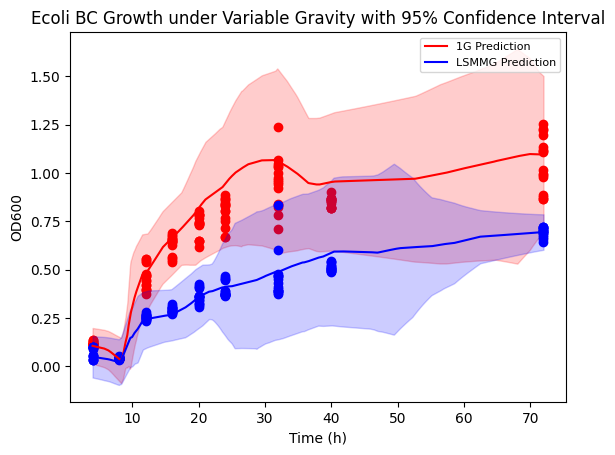

In [ ]:
#Ecoli growth
plot_growth([data_list[2], data_list[3]], color_list_2)

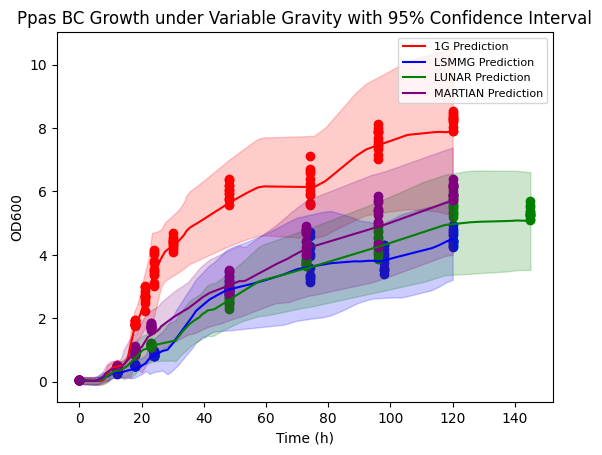

In [ ]:
#Scere BC Growth
plot_growth([data_list[6], data_list[7], data_list[8], data_list[9]], color_list_4)

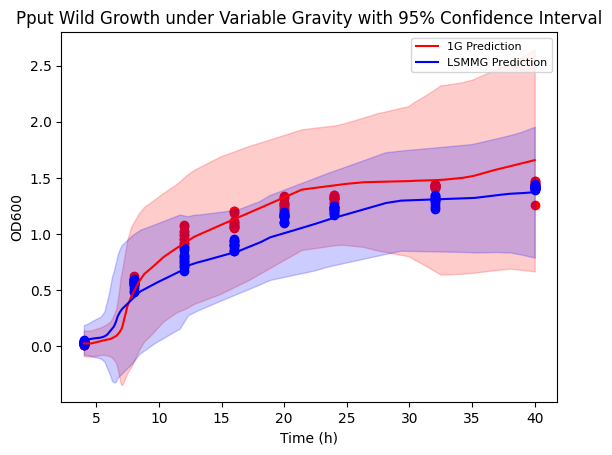

In [ ]:
#Pput Wild Growth
plot_growth([data_list[14], data_list[15]], color_list_2)

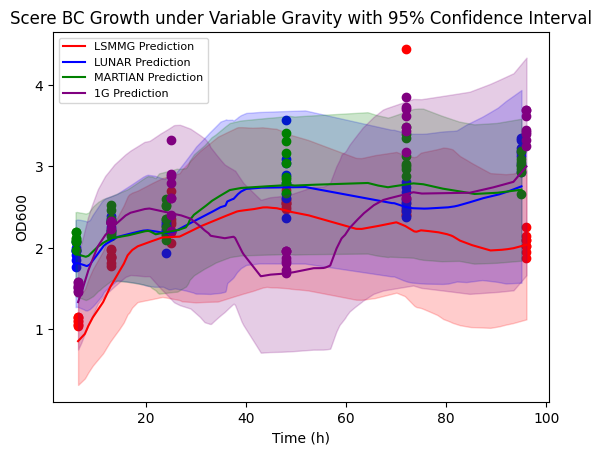

In [ ]:
#Vnat wild growth
plot_growth([data_list[17], data_list[18], data_list[19], data_list[20]], color_list_4)

#Flight data

In [ ]:
import matplotlib.pyplot as plt

Flight 1A

In [ ]:
#!rm *.xlsx
uploaded_1A = files.upload()

Saving Ylipo_BC_1G_1A.xlsx to Ylipo_BC_1G_1A.xlsx
Saving Ylipo_BC_LSMMG_1A.xlsx to Ylipo_BC_LSMMG_1A.xlsx
Saving Ylipo_BC_LUNAR_1A.xlsx to Ylipo_BC_LUNAR_1A.xlsx
Saving Ylipo_BC_MARTIAN_1A.xlsx to Ylipo_BC_MARTIAN_1A.xlsx


In [ ]:
organism_1A_list = []
substance_1A_list = []
gravity_1A_list = []
obj_1A_list = []

In [ ]:
class Preprocess_flight:
  def __init__(self, file_name):
    self.file_name = file_name
    self.organism, self.substance, self.gravity, self.flight = self.file_name.split(".")[0].split()[0].split("_")
    self.update_list(organism_1A_list, self.organism)
    self.update_list(substance_1A_list, self.substance)
    self.update_list(gravity_1A_list, self.gravity)

  def update_list(self, item_list, item):
    #if item not in item_list:
    item_list.append(item)

In [ ]:
for file_name in uploaded_1A.keys():
  obj = Preprocess_flight(file_name)
  obj_1A_list.append(obj)

In [ ]:
def locate_label(var, var_list, var_encode_list):
  index = var_list.index(var)
  return var_encode_list[index]

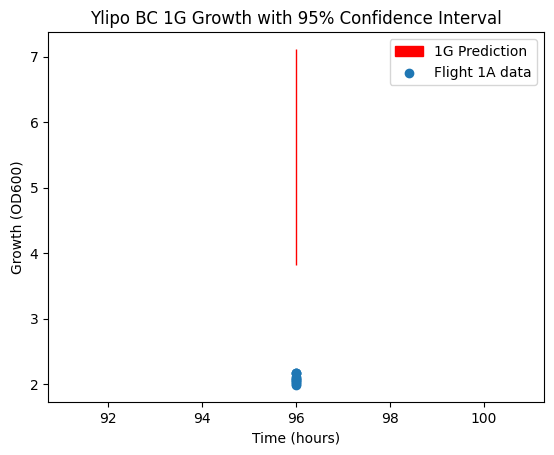

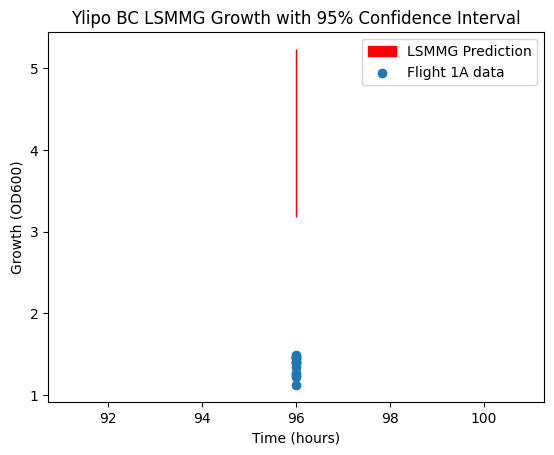

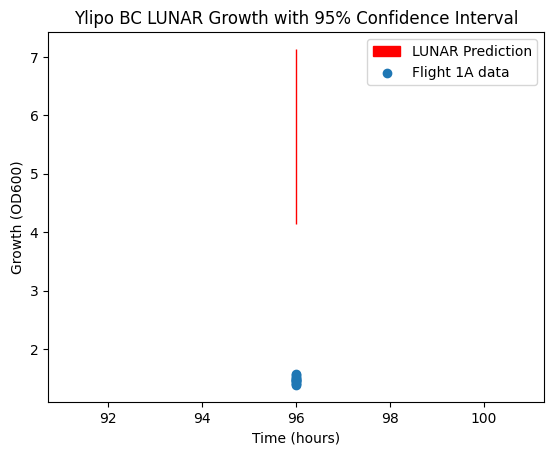

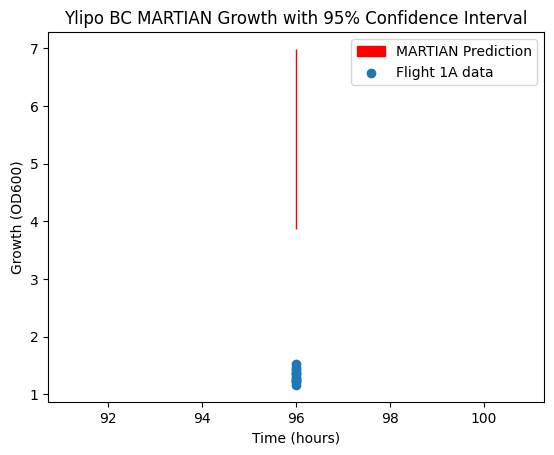

In [ ]:
data_1A_list = []

for i, obj in enumerate(obj_1A_list):
  organism_locate_label = locate_label(obj.organism, organism_list, organism_label)
  substance_locate_label = locate_label(obj.substance, substance_list, substance_label)
  gravity_locate_label = locate_label(obj.gravity, gravity_list, gravity_label)

  #use the combination of labels to locate the correct obj_list item
  data_obj = Data(obj.file_name, organism_locate_label, substance_locate_label, gravity_locate_label)
  data_1A_list.append(data_obj)

  #combine into categorical inputs
  categorical_inputs = [organism_locate_label, substance_locate_label, gravity_locate_label]
  categorical_inputs_transformed = torch.tensor([categorical_inputs]).squeeze()

  #replace time_linspace_tensor, define this as the list of time elements
  time_tensor = torch.tensor(data_obj.growth_input_np[:,3], dtype = torch.float32)
  categorical_inputs_transformed_stacked = torch.Tensor.repeat(categorical_inputs_transformed, len(time_tensor)).reshape(-1, len(categorical_inputs))

  input_unstandardized = torch.hstack((categorical_inputs_transformed_stacked, time_tensor.reshape(-1, 1)))
  input_unstandardized[:,3] = (input_unstandardized[:,3] - growth_time_input_mean) / growth_time_input_std_dev

  input_standardized = input_unstandardized
  predicted_output_mean, predicted_output_std = pnn.get_mean_and_standard_deviation(input_standardized.numpy())
  time_tensor = time_tensor.numpy().flatten()
  predicted_output_mean = predicted_output_mean.flatten()
  predicted_output_std = predicted_output_std.flatten()

  plt.title(f"{organism_encode.inverse_transform([data_obj.organism])[0]} {substance_encode.inverse_transform([data_obj.substance])[0]} {gravity_encode.inverse_transform([data_obj.gravity])[0]} Growth with 95% Confidence Interval")

  plt.fill_between(time_tensor,
                   predicted_output_mean - 3 * predicted_output_std,
                   predicted_output_mean + 3 * predicted_output_std,
                   #alpha = 0.2,
                   color = 'red',
                   label=f"{gravity_encode.inverse_transform([data_1A_list[i].gravity])[0]} Prediction")

  plt.scatter(time_tensor,
              data_obj.growth_val_np,
              label = "Flight 1A data")
  plt.xlabel("Time (hours)")
  plt.ylabel("Growth (OD600)")
  plt.legend()
  plt.show()

Flight 1B

In [ ]:
#!rm *.xlsx
uploaded_1B = files.upload()

In [ ]:
organism_1B_list = []
substance_1B_list = []
gravity_1B_list = []
obj_1B_list = []

In [ ]:
for file_name in uploaded_1B.keys():
  obj = Preprocess_flight(file_name)
  obj_1B_list.append(obj)

In [ ]:
data_1B_list = []

for i, obj in enumerate(obj_1B_list):
  organism_locate_label = locate_label(obj.organism, organism_list, organism_label)
  substance_locate_label = locate_label(obj.substance, substance_list, substance_label)
  gravity_locate_label = locate_label(obj.gravity, gravity_list, gravity_label)

  #use the combination of labels to locate the correct obj_list item
  data_obj = Data(obj.file_name, organism_locate_label, substance_locate_label, gravity_locate_label)
  data_1B_list.append(data_obj)

  #combine into categorical inputs
  categorical_inputs = [organism_locate_label, substance_locate_label, gravity_locate_label]
  categorical_inputs_transformed = torch.tensor([categorical_inputs]).squeeze()

  #replace time_linspace_tensor, define this as the list of time elements
  time_tensor = torch.tensor(data_obj.growth_input_np[:,3], dtype = torch.float32)
  categorical_inputs_transformed_stacked = torch.Tensor.repeat(categorical_inputs_transformed, len(time_tensor)).reshape(-1, len(categorical_inputs))

  input_unstandardized = torch.hstack((categorical_inputs_transformed_stacked, time_tensor.reshape(-1, 1)))
  input_unstandardized[:,3] = (input_unstandardized[:,3] - growth_time_input_mean) / growth_time_input_std_dev

  input_standardized = input_unstandardized
  predicted_output_mean, predicted_output_std = pnn.get_mean_and_standard_deviation(input_standardized.numpy())

  time_tensor = time_tensor.numpy().flatten()
  predicted_output_mean = predicted_output_mean.flatten()
  predicted_output_std = predicted_output_std.flatten()


  plt.title(f"{organism_encode.inverse_transform([data_obj.organism])[0]} {substance_encode.inverse_transform([data_obj.substance])[0]} {gravity_encode.inverse_transform([data_obj.gravity])[0]} Growth with 95% Confidence Interval")

  unique_values, indexes = np.unique(time_tensor, return_index=True)

  for j, index in enumerate(indexes):

    plt.vlines(time_tensor[index],
                   predicted_output_mean[index] - 3 * predicted_output_std[index],
                   predicted_output_mean[index] + 3 * predicted_output_std[index],
                   color = 'red',
                   label=(f"{gravity_encode.inverse_transform([data_1B_list[i].gravity])[0]} Prediction" if j == 0 else ""),
               zorder = 1)

  plt.scatter(time_tensor,
              data_obj.growth_val_np,
              label = "Flight 1B data",
              zorder = 2)
  plt.xlabel("Time (hours)")
  plt.ylabel("Growth (OD600)")
  plt.legend(loc = 'upper left')
  plt.show()